In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn.feature_selection import f_classif, mutual_info_classif
import numpy as np

# Define File Paths & Load to DataFrame

In [2]:
BASE_PATH = './2025_A2/train'
METADATA_PATH = BASE_PATH + '/train_metadata.csv'
metadata = pd.read_csv(METADATA_PATH)   # columns: image_id, ClassId
# test_meta  = pd.read_csv("test_metadata.csv")    # columns: image_id

FEATURE_PATH = BASE_PATH + '/Features'

print(FEATURE_PATH + "/additional_features.csv")

./2025_A2/train/Features/additional_features.csv


# Data Processing

### Join evety feature CSV with ClassID in metadata

In [3]:
# load data
add_feats  = pd.read_csv(FEATURE_PATH + "/additional_features.csv")  
color_hist = pd.read_csv(FEATURE_PATH + "/color_histogram.csv")     
hog_pca    = pd.read_csv(FEATURE_PATH + "/hog_pca.csv")         

hog_pca = hog_pca.merge(
    metadata[["image_path", "ClassId"]],
    on="image_path",
    how="left"
)

add_feats = add_feats.merge(
    metadata[["image_path", "ClassId"]],
    on="image_path",
    how="left"
)

color_hist = color_hist.merge(
    metadata[["image_path", "ClassId"]],
    on="image_path",
    how="left"
)

print(hog_pca.columns, end="\n\n")
print(add_feats.columns, end="\n\n")
print(color_hist.columns, end="\n\n")

Index(['image_path', 'hog_pca_0', 'hog_pca_1', 'hog_pca_2', 'hog_pca_3',
       'hog_pca_4', 'hog_pca_5', 'hog_pca_6', 'hog_pca_7', 'hog_pca_8',
       'hog_pca_9', 'hog_pca_10', 'hog_pca_11', 'hog_pca_12', 'hog_pca_13',
       'hog_pca_14', 'hog_pca_15', 'hog_pca_16', 'hog_pca_17', 'hog_pca_18',
       'hog_pca_19', 'ClassId'],
      dtype='object')

Index(['image_path', 'edge_density', 'mean_b', 'mean_g', 'mean_r', 'ClassId'], dtype='object')

Index(['image_path', 'ch_0', 'ch_1', 'ch_2', 'ch_3', 'ch_4', 'ch_5', 'ch_6',
       'ch_7', 'ch_8', 'ch_9', 'ch_10', 'ch_11', 'ch_12', 'ch_13', 'ch_14',
       'ch_15', 'ch_16', 'ch_17', 'ch_18', 'ch_19', 'ch_20', 'ch_21', 'ch_22',
       'ch_23', 'ch_24', 'ch_25', 'ch_26', 'ch_27', 'ch_28', 'ch_29', 'ch_30',
       'ch_31', 'ch_32', 'ch_33', 'ch_34', 'ch_35', 'ch_36', 'ch_37', 'ch_38',
       'ch_39', 'ch_40', 'ch_41', 'ch_42', 'ch_43', 'ch_44', 'ch_45', 'ch_46',
       'ch_47', 'ch_48', 'ch_49', 'ch_50', 'ch_51', 'ch_52', 'ch_53', 'ch_54',
  

# Data Visualization

### ClassID Distribution

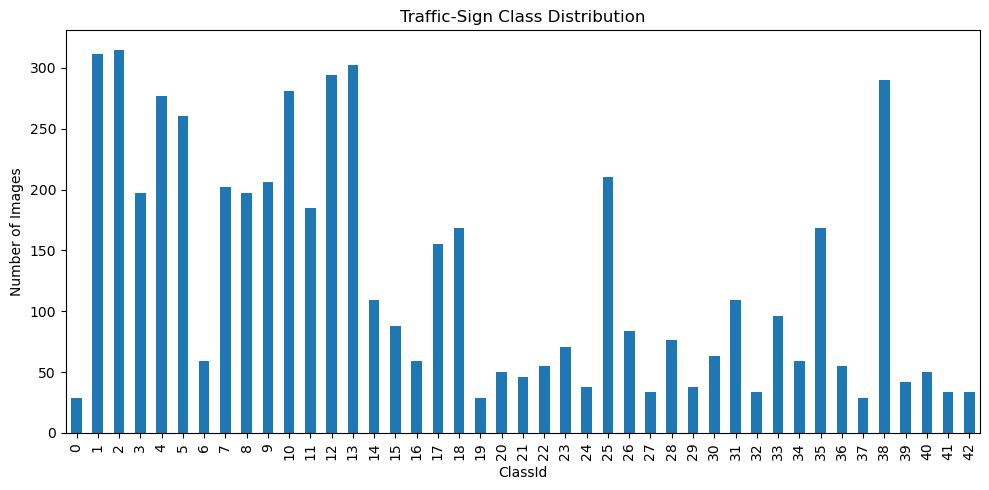

In [4]:
class_counts = metadata["ClassId"].value_counts().sort_index()

# 3. bar-plot the distribution
plt.figure(figsize=(10, 5))
class_counts.plot(kind="bar")               # one bar per ClassId
plt.xlabel("ClassId")
plt.ylabel("Number of Images")
plt.title("Traffic-Sign Class Distribution")
plt.tight_layout()
plt.show()

### Additonal Feature Distribution

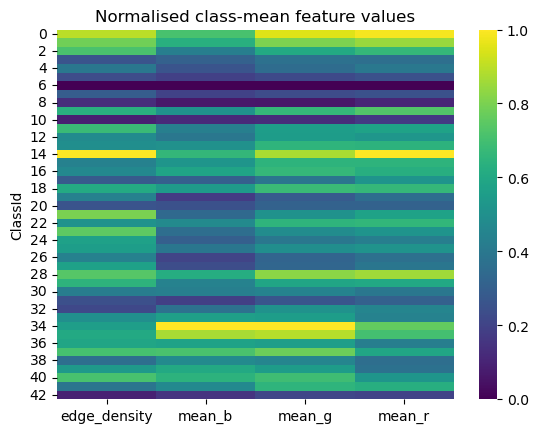

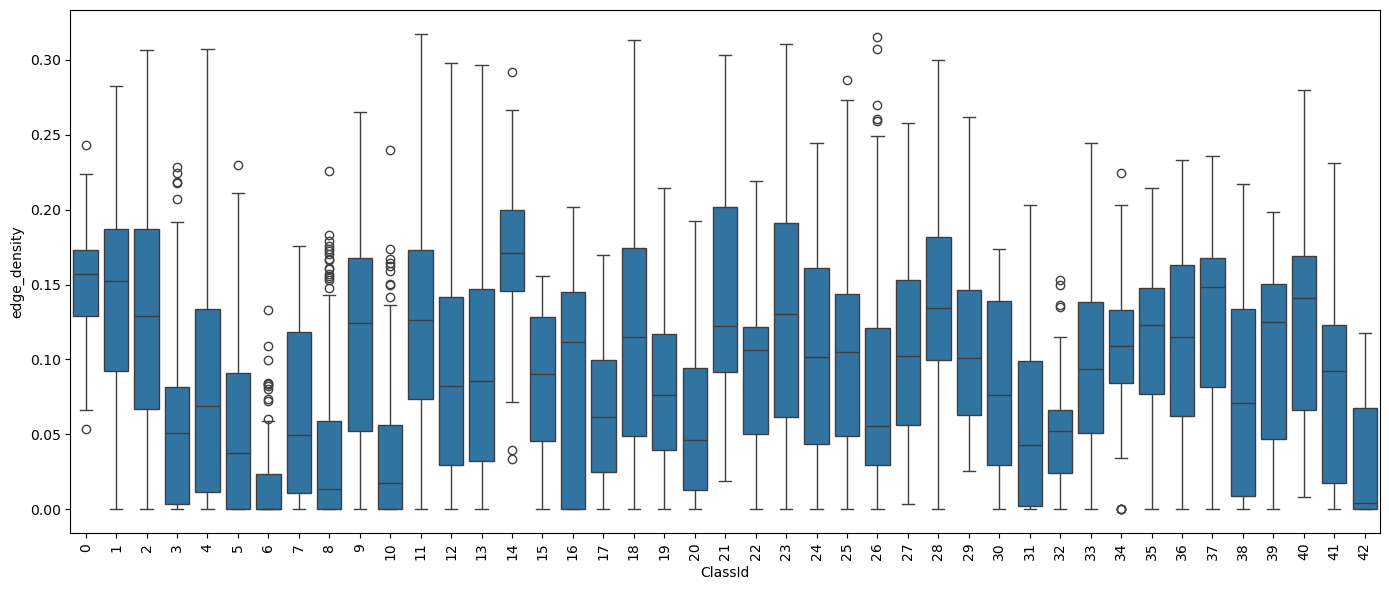

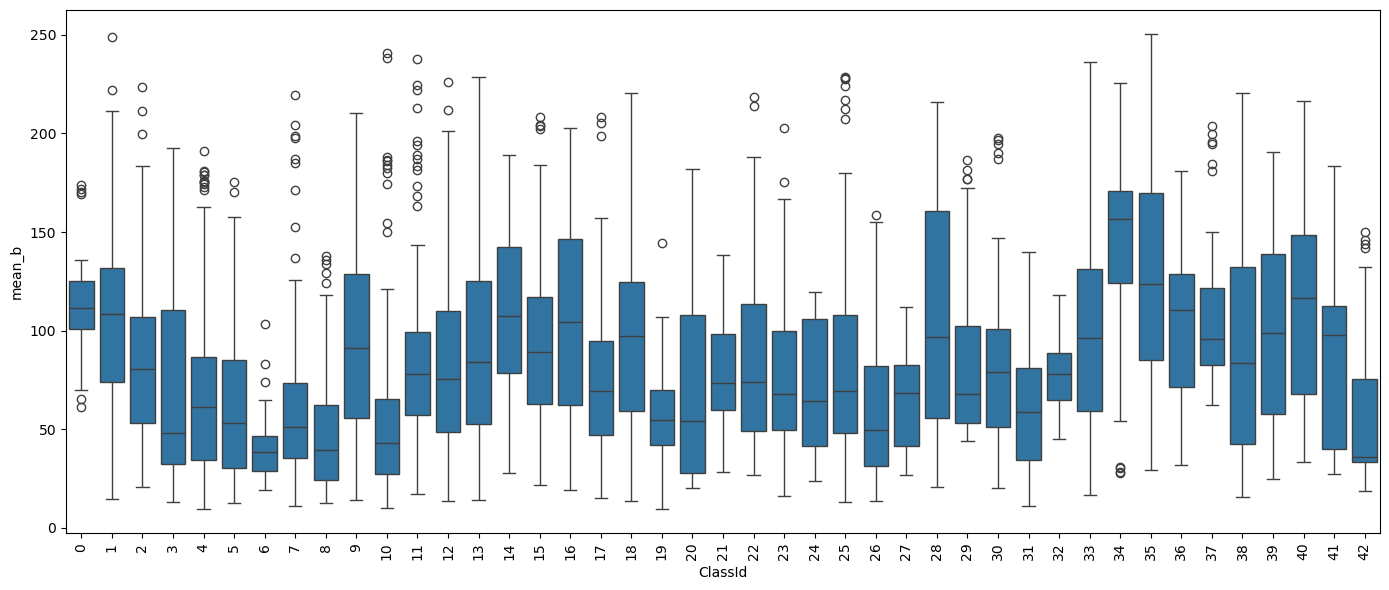

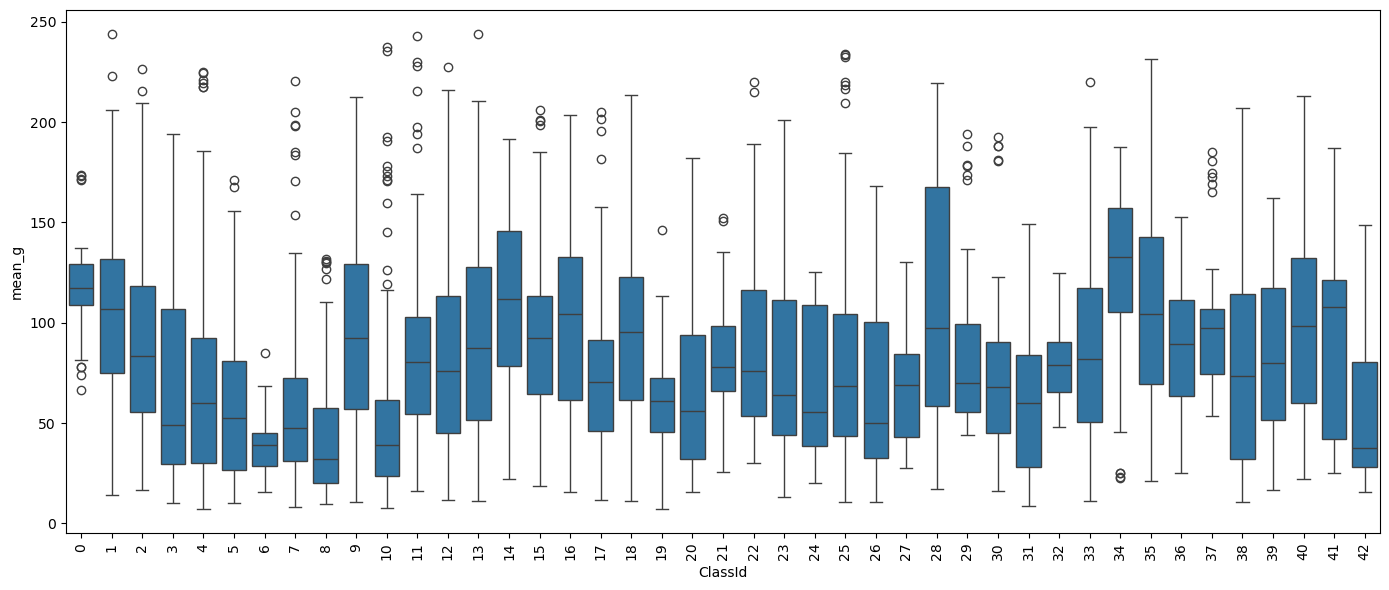

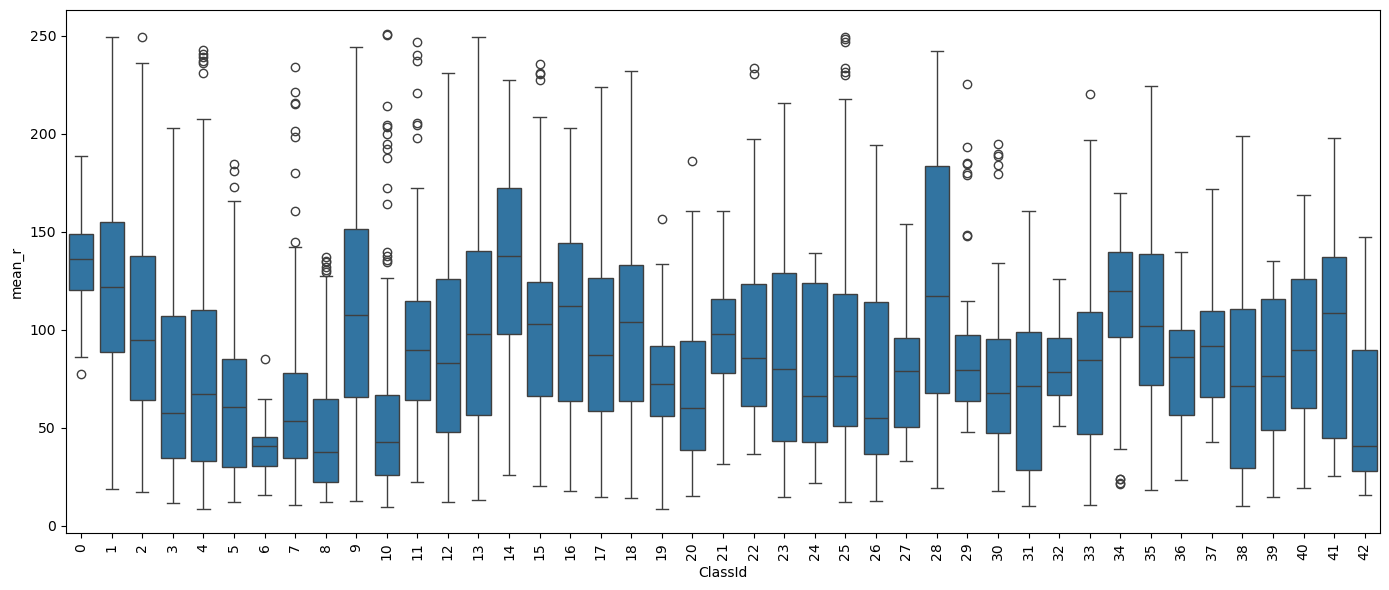

In [5]:
# Correlation matrix
class_means = (
    add_feats.groupby("ClassId")[["edge_density", "mean_b", "mean_g", "mean_r"]]
      .mean()
      .pipe(lambda t: (t - t.min()) / (t.max() - t.min()))  # 0-1 normalise for colour scale
)

# The chart shows potential outlier
sns.heatmap(class_means, cmap="viridis", annot=False, cbar=True)
plt.title("Normalised class-mean feature values"); plt.show()
############################################################
plt.figure(figsize=(14, 6))
sns.boxplot(data=add_feats, x="ClassId", y="edge_density")
plt.xticks(rotation=90); plt.tight_layout(); plt.show()
############################################################
plt.figure(figsize=(14, 6))
sns.boxplot(data=add_feats, x="ClassId", y="mean_b")
plt.xticks(rotation=90); plt.tight_layout(); plt.show()
############################################################
plt.figure(figsize=(14, 6))
sns.boxplot(data=add_feats, x="ClassId", y="mean_g")  
plt.xticks(rotation=90); plt.tight_layout(); plt.show()
############################################################
plt.figure(figsize=(14, 6))
sns.boxplot(data=add_feats, x="ClassId", y="mean_r")
plt.xticks(rotation=90); plt.tight_layout(); plt.show()
############################################################

### HOG_PCA Analysis
 - higher F score means the better feature separates classes 
 - MI (mutual information) value measures from 0 to 1, 0 = independent, 1 = perfectly informative

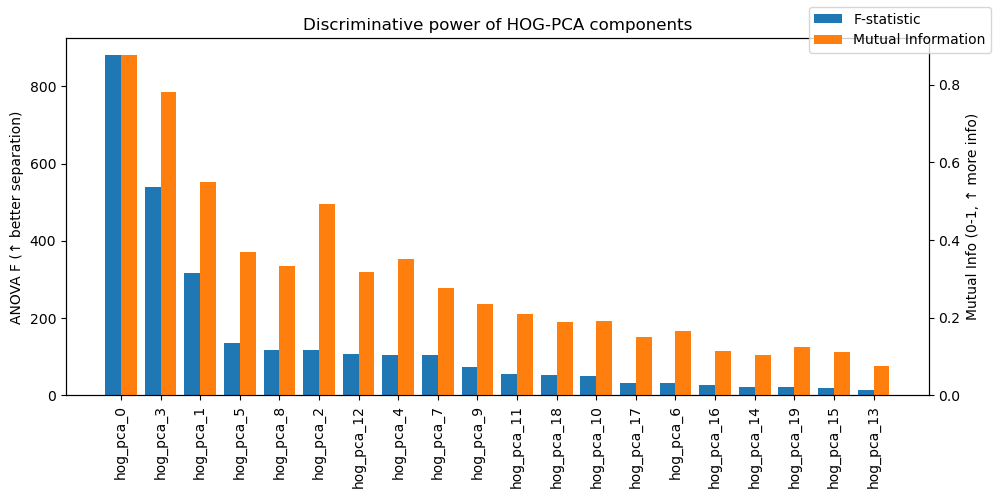

In [13]:
X = hog_pca.filter(like="pc")          # pc1 … pc19
y = hog_pca["ClassId"]

# one-way ANOVA F-scores  (bigger ⇒ better class separation)
F, _  = f_classif(X, y)

# mutual information  (0‒1, bigger ⇒ more information)
MI    = mutual_info_classif(X, y, random_state=0)

feat_rank = pd.DataFrame({"feature": X.columns, "F": F, "MI": MI})\
  .sort_values("F", ascending=False)
  

# cm = hog_pca.groupby("ClassId")[X.columns].mean()
# cm = (cm - cm.min()) / (cm.max() - cm.min())   # 0-1 normalise per PC
# sns.heatmap(cm, cmap="viridis")
# plt.title("Normalised class means of HOG-PCA components")
# plt.show()

feat_rank = feat_rank.sort_values("F", ascending=False)

fig, ax1 = plt.subplots(figsize=(10,5))
ax2 = ax1.twinx()
x = np.arange(len(feat_rank))
ax1.bar(x-0.2, feat_rank["F"], width=0.4, label="F‑statistic", color="tab:blue")
ax2.bar(x+0.2, feat_rank["MI"], width=0.4, label="Mutual Information", color="tab:orange")

ax1.set_ylabel("ANOVA F (↑ better separation)")
ax2.set_ylabel("Mutual Info (0‑1, ↑ more info)")

ax1.set_xticks(x)
ax1.set_xticklabels(feat_rank["feature"], rotation=90)
ax1.set_title("Discriminative power of HOG‑PCA components")

fig.tight_layout()
fig.legend(loc="upper right")
plt.show()

### Color Histogram Analysis


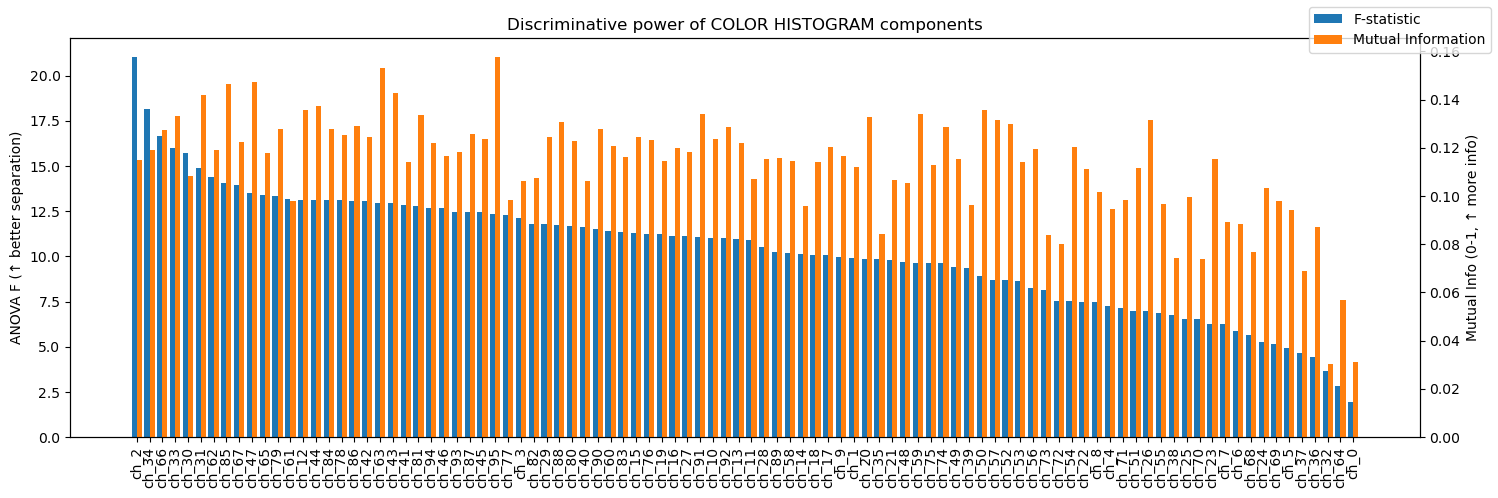

In [15]:
X = color_hist.filter(like="ch")  
y = color_hist["ClassId"]

# one-way ANOVA F-scores  (bigger ⇒ better class separation)
F, _  = f_classif(X, y)

# mutual information  (0‒1, bigger ⇒ more information)
MI    = mutual_info_classif(X, y, random_state=0)

feat_rank = pd.DataFrame({"feature": X.columns, "F": F, "MI": MI})\
  .sort_values("F", ascending=False)
  
# Plot diagram
feat_rank = feat_rank.sort_values("F", ascending=False)

fig, ax1 = plt.subplots(figsize=(15,5))
ax2 = ax1.twinx()
x = np.arange(len(feat_rank))
ax1.bar(x-0.2, feat_rank["F"], width=0.4, label="F‑statistic", color="tab:blue")
ax2.bar(x+0.2, feat_rank["MI"], width=0.4, label="Mutual Information", color="tab:orange")

ax1.set_ylabel("ANOVA F (↑ better separation)")
ax2.set_ylabel("Mutual Info (0‑1, ↑ more info)")

ax1.set_xticks(x)
ax1.set_xticklabels(feat_rank["feature"], rotation=90)
ax1.set_title("Discriminative power of COLOR HISTOGRAM components")

fig.tight_layout()
fig.legend(loc="upper right")
plt.show()